# Deep Learning Project: Image Super-Resolution

```
Course Instructor: 
+ Nikos Deligiannis
Teaching Assistants:
+ Lusine Abrahamyan
+ Giannis Bekoulis

Student Group:
+ Esteban Velásquez Rendón
+ Andrzej Krzysztof Pietrusiak
+ Amna Jouini

MSc. Applied Computer Science 2021-2022
```

# DATA


Before importing data make sure project has following structure  
[link to data folder](https://vub-my.sharepoint.com/:f:/g/personal/andrzej_krzysztof_pietrusiak_vub_be/Epf4LoQX_D9Euude-yENLmgBRVpu0VFMeMONZA9vmfUJXQ)

<pre>
project folder:  
│  
│── main.ipynb  
│   
└───data    
    ├───DIV2K_train_HR/
    ├───DIV2K_valid_HR/
    ├───DIV2K_train_LR_bicubic/
    └───DIV2K_valid_LR_bicubic/
</pre>

# Imports

In [1]:
import cv2 # computer vision librart
import os  # libray to work with paths and systems
from tqdm.notebook import tqdm # progress bar for jupyter notebooks
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import gc
from skimage.metrics import structural_similarity as ssim

# Create data for NN
- input patches
- label patches
- input HR
- input LR

In [6]:
def create_patches(path:str, base_size=(2000, 1000) ,patch_size=(150,150), N_of_pathches=1, resolution_divider=10, train_percent:float= 0.8 ):
    if path[-1] != '/':
        path+= '/'
    i=0

    hr_big=[]
    patch_hr=[]
    file_names=[]

    # READ FILES, GET patches in high resolution
    class enough_patches(Exception):
        pass
    try:
        for file in os.listdir(path) :

            if file.split(".")[-1] != "png": # IF FILE FORMAT NOT CORRECT -> SKIP
                continue
            i+=1
            #Read image, acomodate its size
            img = cv2.imread(path + file)   
            #img = cv2.resize(img, base_size, interpolation = cv2.INTER_AREA)

            if img.shape[0]< patch_size[0] or img.shape[1] < patch_size[1]: # IMG SMALLER THAN PATCH
                continue

            file_names.append(file)
            
            hr_big.append(img)

            w,h=int(patch_size[0]/1.01), int(patch_size[1]/1.01)
            for x in range(0, img.shape[0]-h, h ):
                for y in range(0, img.shape[1]-w, w ):
                    cropped= img[x:x+h, y:y+w]
                    patch_hr.append(cropped)
                    if len(patch_hr) > N_of_pathches:
                        raise enough_patches
               
    except enough_patches:
        pass

    # GET downsampled and upsampled patches from previously read data
    patch_lr=[]
    for p_hr in patch_hr:
        downsampled = cv2.resize(p_hr, (int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider)), interpolation = cv2.INTER_AREA)
        upsample= cv2.resize(downsampled, (p_hr.shape[0], p_hr.shape[1]), interpolation=cv2.INTER_CUBIC) 
        patch_lr.append(upsample)
    

    #Pathes lists To numpy
    patch_hr_np=np.array(patch_hr)
    patch_lr_np=np.array(patch_lr)
    hr_big=np.array(hr_big)

    # Train-Test split
    indices = np.random.permutation(patch_hr_np.shape[0])
    split_point=int(patch_hr_np.shape[0]*train_percent)
    training_idx, test_idx = indices[:split_point], indices[split_point:] 
    patch_hr_np_training, patch_hr_np_test = patch_hr_np[training_idx,:], patch_hr_np[test_idx,:]
    patch_lr_np_training, patch_lr_np_test = patch_lr_np[training_idx,:], patch_lr_np[test_idx,:]

    # Normalization
    patch_hr_np_training_normalized=    patch_hr_np_training    /255.0
    patch_lr_np_training_normalized=    patch_lr_np_training    /255.0
    patch_hr_np_test_normalized=        patch_hr_np_test        /255.0
    patch_lr_np_test_normalized=        patch_lr_np_test        /255.0
    hr_big= hr_big/255.0
    if len(hr_big) == 1:
        hr_big=np.expand_dims(hr_big, axis=0)

    # from numpy to tensors
    hr_train=   torch.tensor(   np.transpose(patch_hr_np_training_normalized,       (0, 3, 1, 2) )  ).float()
    lr_train=   torch.tensor(   np.transpose(patch_lr_np_training_normalized,       (0, 3, 1, 2) )  ).float()
    hr_test=    torch.tensor(   np.transpose(patch_hr_np_test_normalized,           (0, 3, 1, 2) )  ).float()
    lr_test=    torch.tensor(   np.transpose(patch_lr_np_test_normalized,           (0, 3, 1, 2) )  ).float()
    #hr_big=     torch.tensor(   np.transpose(hr_big,                                (0, 3, 1, 2) )  ).float()
    

    if hr_train.dtype!=torch.float32 or lr_train.dtype!=torch.float32 or hr_test.dtype!=torch.float32 or lr_test.dtype!=torch.float32:
        raise TypeError

    return hr_train, lr_train, hr_test, lr_test, hr_big, file_names


hr_train, lr_train, hr_test, lr_test,  hr_big, file_names= create_patches(path="./data/DIV2K_train_HR", N_of_pathches=400)

C:\Users\siaka\AppData\Local\Temp\ipykernel_12796\3992342263.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hr_big=np.array(hr_big)


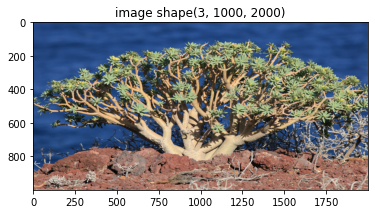

In [198]:
plot(hr_big)

In [180]:
def plot(img):
   img= img.detach().numpy()
   if img.shape[0]==1:
      plt.imshow(cv2.cvtColor( np.transpose(img[0,:,:,:], (1, 2, 0) ), cv2.COLOR_BGR2RGB ))
      plt.title(f"image shape{img[0,:,:,:].shape}")

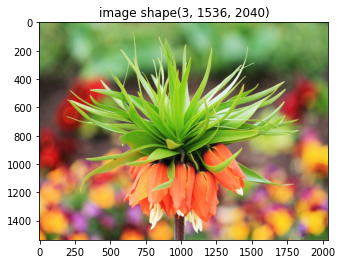

In [185]:
plot(hr2K)

# My example


In [152]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=9, padding= 9//2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [153]:
mySRCNN=SRCNN()
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(stupidModel.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(mySRCNN.parameters(), lr=0.001)
batch_size=16
running_loss = 0.0
epochs=10
loss_vals=[]
best_epoch=0

mySRCNN.train()
for e in tqdm(range(epochs)):
        for i in range(0, len(lr_train), batch_size):  # loop over the dataset multiple times

                batch_x=  lr_train[i:i+batch_size]
                batch_y=  hr_train[i:i+batch_size]
                
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = mySRCNN(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        loss_vals.append(loss.item())
        #print(e, end=" ")

        #torch.save(stupidModel.state_dict(), "./models/m"+str(e))

print('Finished Training')


  0%|          | 0/10 [00:00<?, ?it/s]

Finished Training


In [186]:
r= mySRCNN(hr2K)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


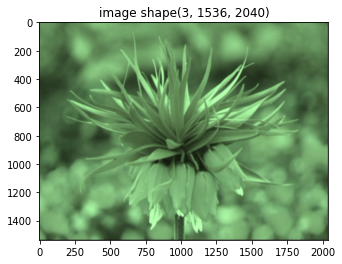

In [154]:
results= mySRCNN(lr_test)

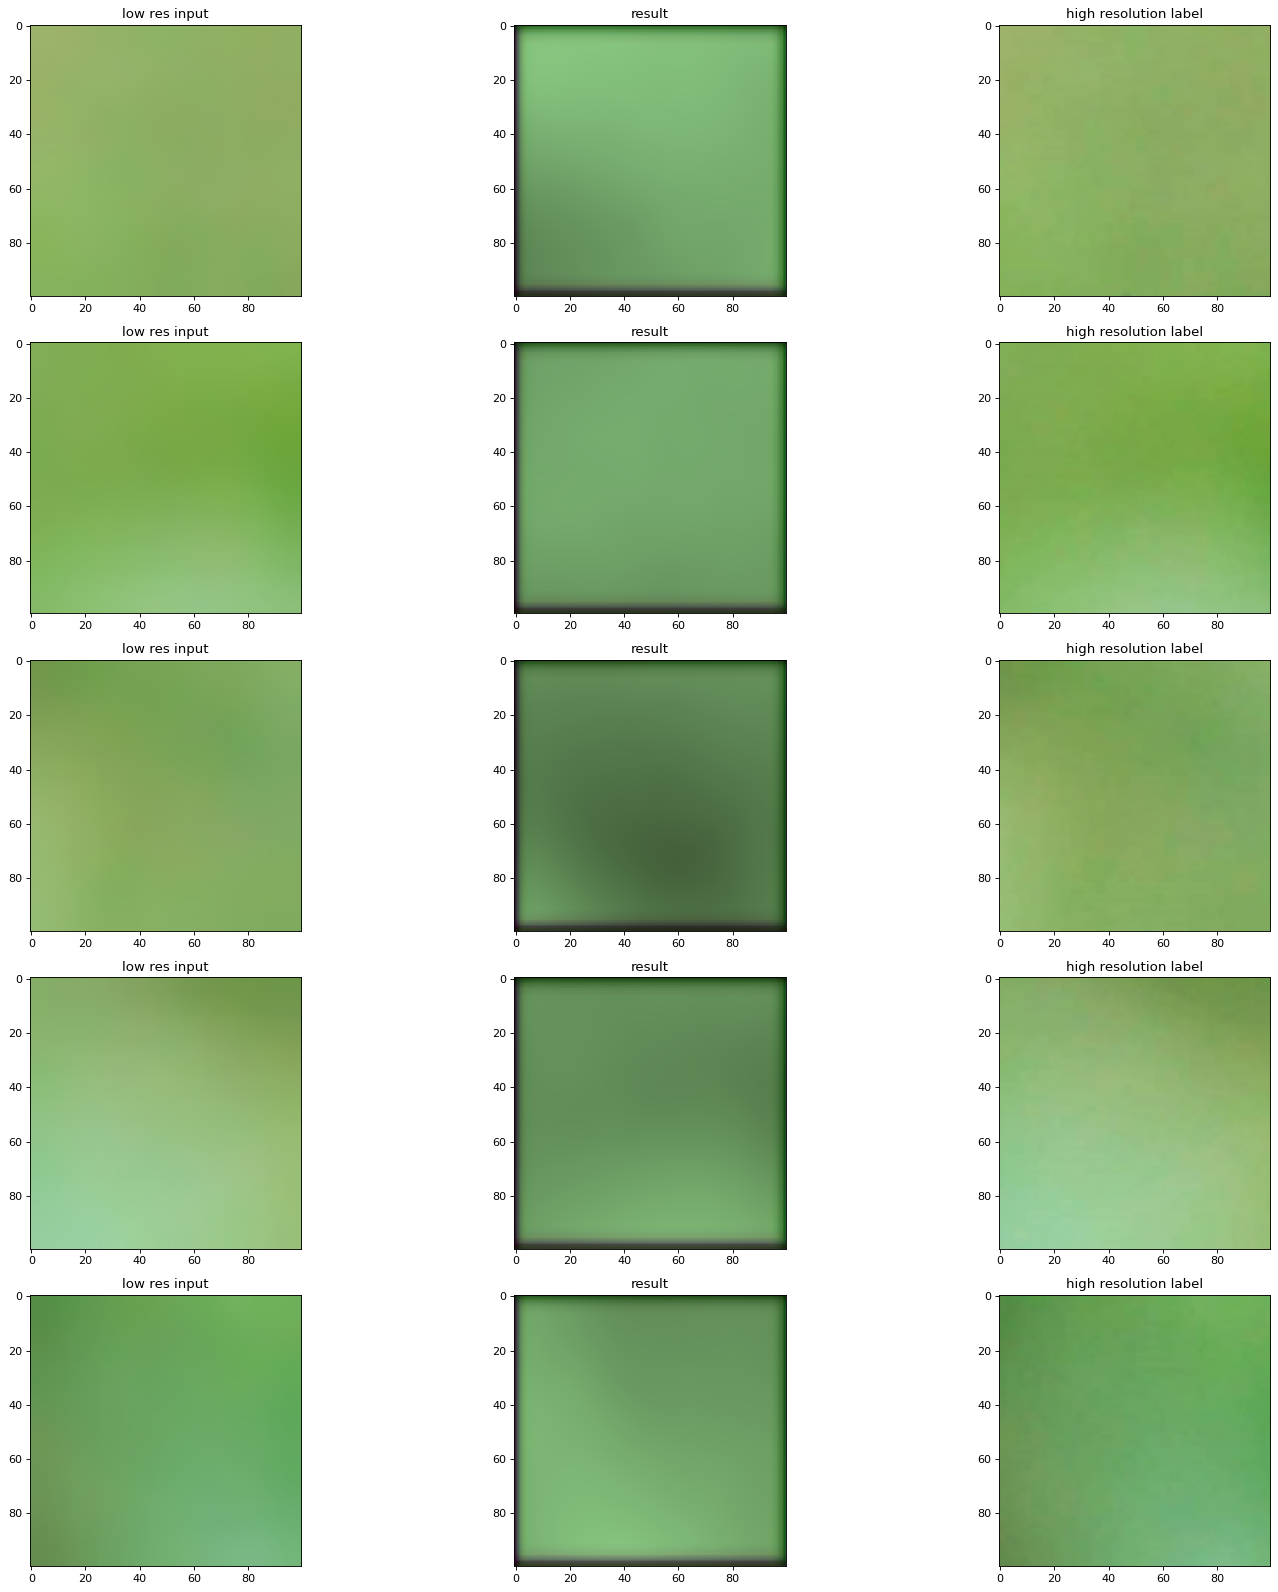

In [183]:
def plot_results(N_of_images_to_plot:int=2, col1:torch.Tensor=None, col2:torch.Tensor=None, col3:torch.Tensor=None, figsize=None, start_from_image=0):
    col1=col1.detach().numpy()
    col2=col2.detach().numpy()
    col3=col3.detach().numpy()

    if figsize == None:
        figsize=( 20,N_of_images_to_plot*4)
    fig, axs = plt.subplots(N_of_images_to_plot, 3, figsize=figsize, dpi=80)
    for i, ax in enumerate(axs):
        i+=start_from_image
        ax[0].imshow( cv2.cvtColor(         np.transpose(col1[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[0].set_title("low res input")
        ax[1].imshow( cv2.cvtColor(         np.transpose(col2[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[1].set_title("result")
        ax[2].imshow( cv2.cvtColor(         np.transpose(col3[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[2].set_title("high resolution label")
    fig.tight_layout()


plot_results(5,col1=lr_test, col2=results, col3=hr_test, start_from_image=2)

In [151]:
r= mySRCNN(hr_test[:2])

NameError: name 'mySRCNN' is not defined